In [1]:
import pickle
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import statistics as st
import os
import glob
import scipy.optimize as opt
import pandas as pd
import datetime
import pyarrow as pyarr
import warnings

%matplotlib inline

%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             if(file[:2]=="C2" or file[:2]=="C1" ):
                filelist.append(os.path.join(root,file))
    return filelist

def getValues(files,skip,nFiles=-1,findex=0,single=False):
    theone={}
    if(single):
        values={"Time":np.array([]),"Ampl":np.array([])}
        with open(files[findex]) as f:
            for i in range(0,skip):
                try:
                    next(f)
                except:
                    continue
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values["Time"]=np.append(values["Time"],float(splitline[0]))
                values["Ampl"]=np.append(values["Ampl"],float(splitline[1]))
        theone[0]=values
        f.close()
        
    else:
        count=0
        for k in files:
            values={"Time":np.array([]),"Ampl":np.array([])}
            with open(k) as f:
                for i in range(0,skip):
                    try:
                        next(f)
                    except:
                        continue
                lines=f.readlines()
                for line in lines:
                    splitline=line.split(",")
                    values["Time"]=np.append(values["Time"],float(splitline[0]))
                    values["Ampl"]=np.append(values["Ampl"],float(splitline[1]))
            theone[count]=values
            count+=1
            f.close()
            if(nFiles==count): 
                break

    return theone

def getMultiEventValues(files,nFiles=-1,EventLim=-1):
    theone={}
    EventCount=1
    PointCount=1
    FileCount=0
    for k in files:
        values={}
        with open(k) as f:
            lines=f.readlines()
            info={}
            for line in lines:
                splitline=line.strip().split(",")
                if(splitline[0]=="Segments"):
                    info[splitline[0]]=int(splitline[1])
                    info[splitline[2]]=int(splitline[3])
                    continue

                if("Time" in values.keys()):
                    values["Time"]=np.append(values["Time"],float(splitline[0]))
                    values["Ampl"]=np.append(values["Ampl"],float(splitline[1]))
                    
                    if(PointCount==info["SegmentSize"]):
                        theone[EventCount]=values.copy()
                        
                        values["Time"]=np.array([])
                        values["Ampl"]=np.array([])
                        EventCount+=1
                        PointCount=0
                    
                    PointCount+=1
                else:
                    if (splitline[0]=="Time"):
                        values["Time"]=np.array([])
                        values["Ampl"]=np.array([])
                        
                        print(f"Collecting data from {FileCount} ")
                    continue;
                if (EventCount==EventLim or (EventLim!=-1 and EventCount>EventLim)):
                    break
                    
                    
        FileCount+=1
        f.close()
        if(nFiles==FileCount): 
            break

    return theone

def Smoothing(data,itteration):
    S_time=np.zeros(len(data["Time"]))
    S_amp=np.zeros(len(data["Ampl"]))
    for t in range(len(data["Time"])):
        if(t<itteration):
            S_time[t]=np.mean(data["Time"][:t+1])
            S_amp[t]=np.mean(data["Ampl"][:t+1])
        else:
            #S_amp[t]=np.sum(data["voltage"][t-itteration:t])/itteration
            #S_time[t]=np.sum(data["time"][t-itteration:t])/itteration
            S_amp[t]=np.mean(data["Ampl"][t-itteration:t])
            S_time[t]=np.mean(data["Time"][t-itteration:t])
    return S_amp,S_time



## Peak Finder for Osiloscope info
def PeakFinder(data,step=1e-9,threshold=-0.01):
    
    print("Running Peak Finder Algorithm ..")
    ## First Get the lenth of the time
    Length=len(data["Ampl"])
    VoltageProfile=np.array([])
    TimeProfile=np.array([])
    AllTime=np.array([])
    ## Obtain the max and min time
    MinTime=np.min(data["Time"])
    MaxTime=np.max(data["Time"])
    
    
    #Start Time
    TempTime=MinTime
    
    print(f"Max time is {MaxTime}")
    print(f"Min time is {MinTime}")
    print(f"Event Length is {Length}")

    for i in range(0, Length):
        if(TempTime>MaxTime):
            print("Max Time is reached")
            break
            
        TimeMask=(data["Time"]>=TempTime) & (data["Time"]<TempTime+step ) 
        
        ## Check if there is any peak here
        if(np.sum(TimeMask)==0):
            TempTime=TempTime+step
            continue
         
        ## Obtain the minum
        Min=np.min(data["Ampl"][TimeMask])
        VoltageMask=data["Ampl"][TimeMask]==Min
        AllTime=np.append(AllTime,data["Time"][TimeMask][VoltageMask])
        ## Only Negative Pulse
        if(Min<threshold and (not Min>0)):
            TimeProfile=np.append(TimeProfile,data["Time"][TimeMask][VoltageMask])
            VoltageProfile=np.append(VoltageProfile,data["Ampl"][TimeMask][VoltageMask])

        TempTime=TempTime+step 
    print(f"Number of Peaks is {len(TimeProfile)}")
    return TimeProfile,VoltageProfile,AllTime



def PeaksPerUnitTime(TProf,StartTime,EndTime):
    Mask=(TProf>=StartTime) & (TProf<EndTime)
    return np.sum(Mask)
    
### Get Number of peaks per unit time

def gaussian1d(x,A,mu,sigma):
    return A*np.exp( - (x - mu)**2 / (2 * sigma**2))

def MultiPeakFit(values,step,threshold):
    mean=np.array([])
    std=np.array([])
    for value in values:
        v=PeakFinder(value,step,threshold)
        h1=np.histogram(vv[0],bins=40)

        p0=np.max(h1[1]),1e-5,1e-6
        xx=np.linspace(np.min(h1[1]),np.max(h1[1]),len(h1[0]))
        popt, pcov = opt.curve_fit(gaussian1d,xx,h1[0],p0,maxfev=10000)
        
        mean=np.append(mean,popt[1])
        std=np.append(std,popt[2])
    return mean,stdkk


def PickleITDump(data,fileName):
    print("Saving waveforms ..")
    startTime=datetime.datetime.now()
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
    endTime=datetime.datetime.now()
    print(f"Total Time is {endTime-startTime}")    

def PickleITRead(fileName):
    print("Reading waveforms ..")
    startTime=datetime.datetime.now()
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    endTime=datetime.datetime.now()
    print(f"Total Time is {endTime-startTime}")

    return data
def getValuesWithPanda(files,nFiles=-1):
    fthones={}
    cnt=0
    print("Reading Waveforms ..")
    if(nFiles!=-1):
        print(f"Collecting {nFiles}")
    else:
        print(f"Collecting {len(files)} ")
    startTime=datetime.datetime.now()
    for file in files:
        if (nFiles>0 and nFiles<cnt ):
            break
        fvalue=pd.read_csv(file,skiprows=4)
        fthones[cnt]=fvalue
        cnt=cnt+1
    endTime=datetime.datetime.now()
    
    print(f"Total Time is {endTime-startTime}")
    return fthones
def getValuesWithPyArrrow(files,nFiles=-1):
    fthones={}
    cnt=0
    print("Reading Waveforms ..")
    if(nFiles!=-1):
        print(f"Collecting {nFiles}")
    else:
        print(f"Collecting {len(files)} ")
    startTime=datetime.datetime.now()
    read_options=pyarr.csv.ReadOptions(skip_rows=4)
    for file in files:
        if (nFiles>0 and nFiles<cnt ):
            break
        
        fvalue=pyarr.csv.read_csv(file,read_options=read_options)
        fthones[cnt]=fvalue
        cnt=cnt+1
    endTime=datetime.datetime.now()
    
    print(f"Total Time is {endTime-startTime}")
    return fthones
            
## read files with pandas or pyarrow            
def ConvertToPickleFile(fPath,engine="pandas"):
    print(f"Converting {fPath} waveforms into picklefile")
    files=ListofFiles(fPath)
    if(engine=="pandas"):
        fvalues=getValuesWithPanda(files)
    if(engine=="pyarrow"):
        fvalues=getValuesWithPyArrrow(files)
    PickleITDump(fvalues,fPath+"all_files.p")
    return fvalues

In [3]:
user=os.getenv('USER')
#Path="/media/"+user+"/Ilker_SSD/10_07bar_6_21_23/Osiloscope/13.57k_4.57k_4k/vel/"
Path="../data/CRAB_9_17_2023_Osiloscope/17k_8k_7k/velocity/"

In [4]:
#values=ConvertToPickleFile(Path)
#del values

In [5]:
values=PickleITRead(Path+"all_files.p")


Reading waveforms ..
Total Time is 0:00:01.739985


In [6]:
## Event Selection
sevent=values[30]
event=sevent.copy()
## DC offset Remove
Dc_upperLim=np.min(event["Time"])*0.9
DC_Offset=np.mean(event["Ampl"][(event["Time"]>np.min(event["Time"])) & (event["Time"]<(Dc_upperLim))])
event["Ampl"]=event["Ampl"]-DC_Offset

#time shift
minTime=abs(np.min(event["Time"]))
event["Time"]=event["Time"]+minTime

In [7]:
# Smooth it , result of smooting  0 is voltage profile, and s1[1] time  profile


In [8]:
s1=Smoothing(event,1000)
#Create Mask for min voltage and max time 
VoltMinMask=s1[0]==np.min(s1[0])
s1=Smoothing(event,2000)
TimeMaxMask=s1[1]==np.max(s1[1])
TimeMask=(s1[1]>s1[1][TimeMaxMask]*(0.99))
PulseMean=np.average(s1[1][TimeMask])
## Find the Leading Edge
LaggingEdge=s1[1][VoltMinMask]*(0.95)
LeadingEdge=s1[1][VoltMinMask]*(1.05)

#Find the S2 Edge
EdgeMask=(s1[0]<-0.0001) & ((s1[1]>LaggingEdge) & (s1[1]<LeadingEdge))
### Values for time and voltage , step in seconds and threshold in mv

## Seperating Events to S1 and S2 region
EventTime=np.array(event["Time"])
S1_Region={"Time":event["Time"][EventTime<LaggingEdge],"Ampl":event["Ampl"][EventTime<LaggingEdge]}
S2_Region={"Time":event["Time"][EventTime>=LaggingEdge],"Ampl":event["Ampl"][EventTime>=LaggingEdge]}

## Find Peaks in each region
S1Peaks=PeakFinder(S1_Region,step=1e-6,threshold=-0.001)
S2Peaks=PeakFinder(S2_Region,step=1e-7,threshold=-0.001)
#PeaksPerUnitTime(kk[0],-2e-5,-1.2e-5)


Running Peak Finder Algorithm ..
Max time is 0.00017460399730000002
Min time is 0.0
Event Length is 43652
Max Time is reached
Number of Peaks is 1
Running Peak Finder Algorithm ..
Max time is 0.000200003997
Min time is 0.0001746079973
Event Length is 6350
Max Time is reached
Number of Peaks is 98


In [9]:
def TimeDifference(S1Peaks,S2Peaks):
    difs=np.array([])
    for time in S1Peaks[0]:
        difs=np.append(difs,S2Peaks[0][0]-time)
    return difs
        
    

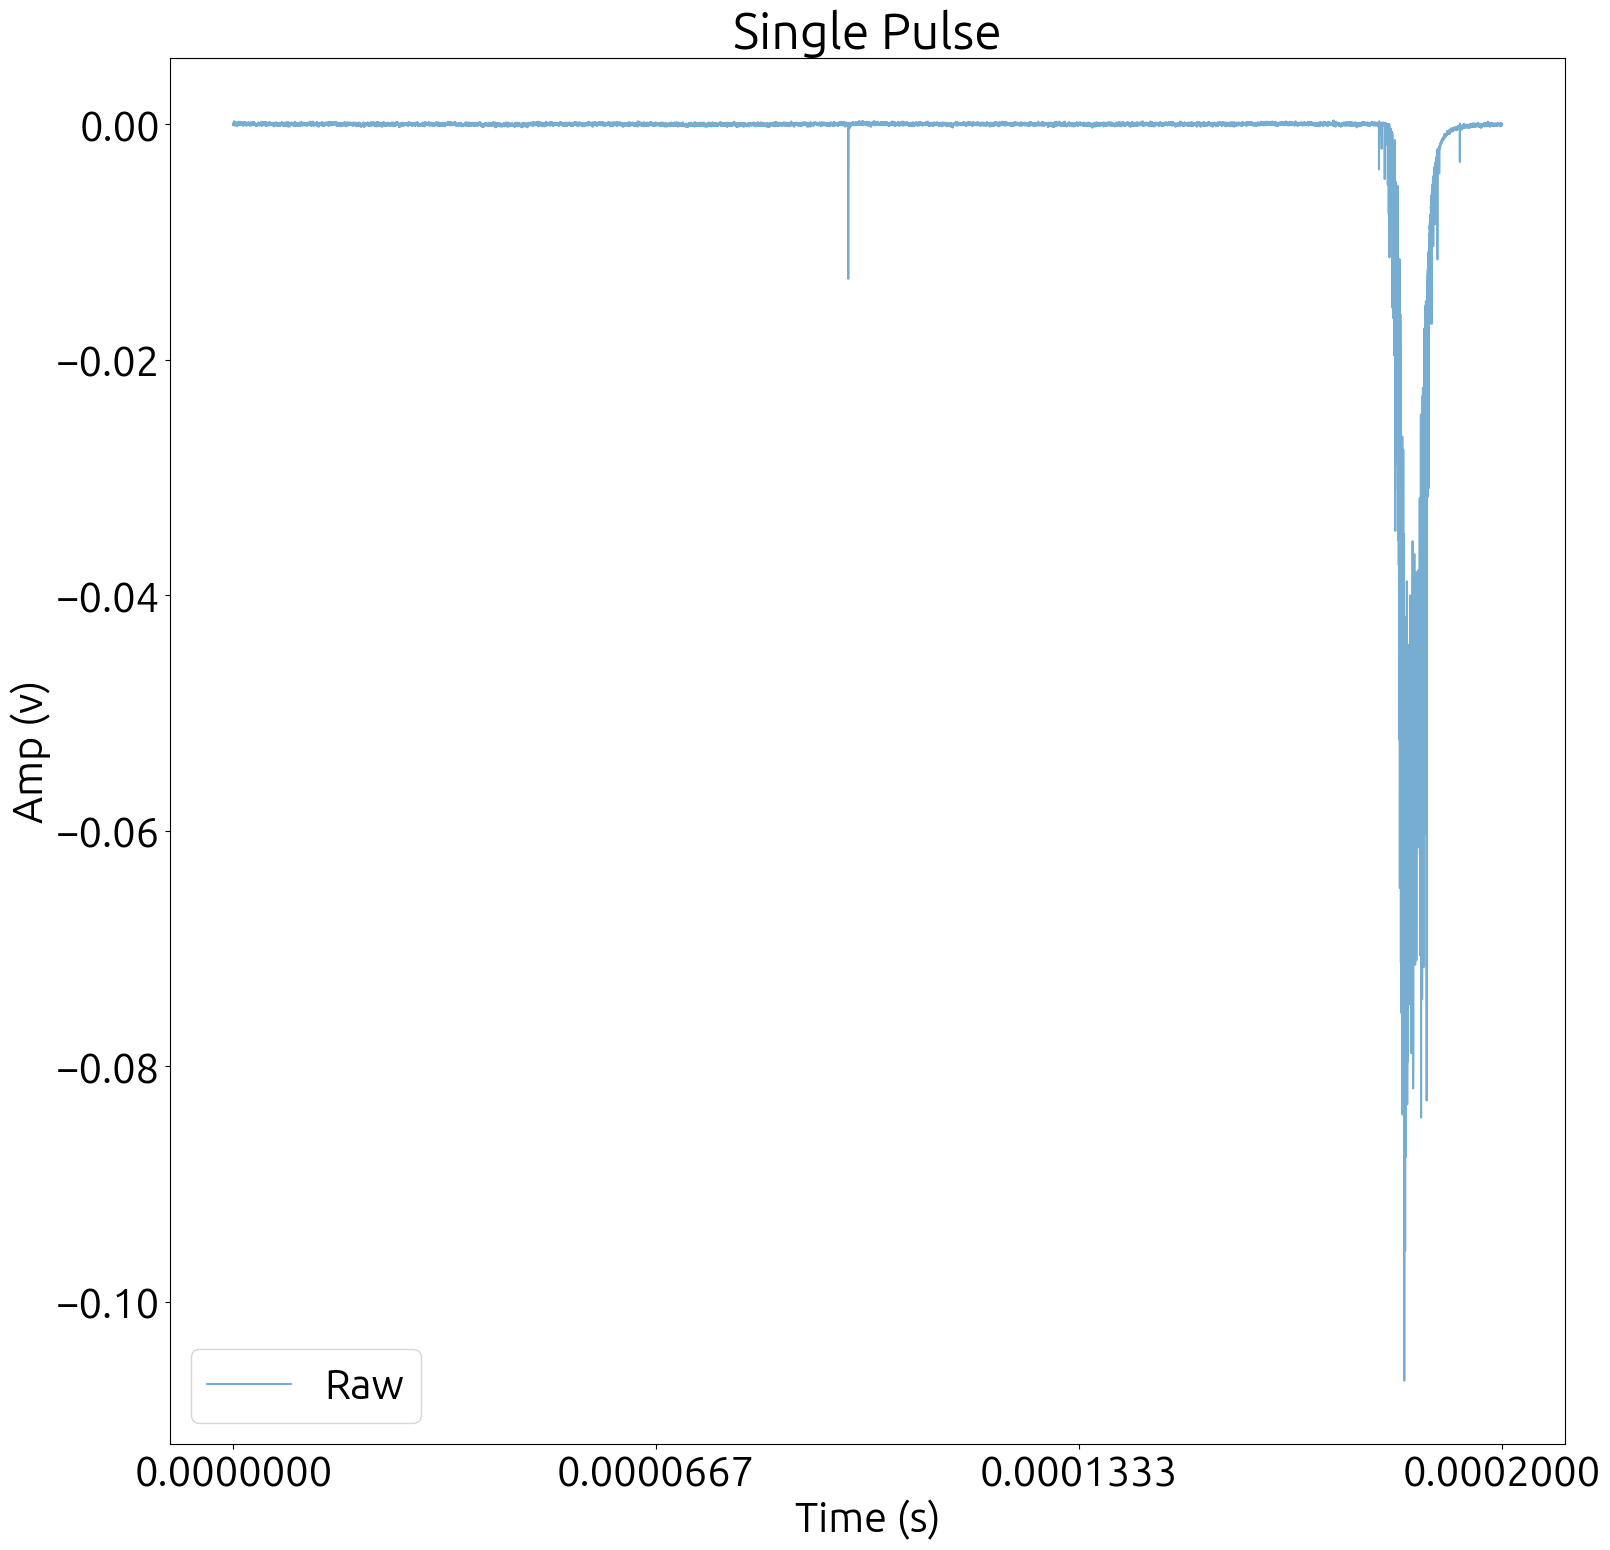

In [29]:

## Plot Waveforms
plt.figure(figsize=(18,18))
plt.title("Single Pulse")
plt.xlabel("Time (s)")
plt.ylabel("Amp (v)")
xtick=np.linspace(np.min(event["Time"]),np.max(event["Time"]),4)
plt.plot(event["Time"],event["Ampl"],label="Raw",alpha=0.6)
plt.xticks(xtick)
#plt.plot(s1[1],s1[0],label="smooted",color="brown")
#plt.axvline(np.min(s1[1]),-1,color="red",label="Min Time")
#plt.axvline(s1[1][VoltMinMask],-1,color="purple",label="Min Voltage")
#plt.axvline(s1[1][TimeMaxMask],-1,color="yellow",label="Max Time")
#plt.axvline(LaggingEdge,-1,color="green",label="S2 Low Limit")
#plt.axvline(LeadingEdge,-1,color="green",label="S2 High Limit")
#plt.axvline(np.min(s1[1][EdgeMask]),-1,color="aqua",label="Lagging Edge")
#plt.axvline(np.max(s1[1][EdgeMask]),-1,color="aqua",label="Leading Edge")

#plt.axvline(Dc_upperLim,-1,label=("DC_UpperLimit"),color="orange")
#plt.axvline(,-1,color="yellow",label="Negative Slope")
#plt.axvline(PulseMean,-1,color="aqua",label="Mean")
#plt.scatter(S1Peaks[0],S1Peaks[1],marker="^",color="red",s=100,label="S1 Peaks")
#plt.scatter(S2Peaks[0],S2Peaks[1],marker="^",color="orange",s=100,label="S2 Peaks")

p0=np.min(s1[0]),np.mean(s1[1][VoltMinMask]),1e-6
popt, pcov = opt.curve_fit(gaussian1d,s1[1],s1[0],p0,maxfev=10000)
#plt.plot(s1[1],gaussian1d(s1[1],*popt),color="black",label="Fit to Smoothed Event")
#plt.scatter(s1[1][EdgeMask],s1[0][EdgeMask],color="aqua",label="Edged_Trigger")

plt.legend()
plt.show()


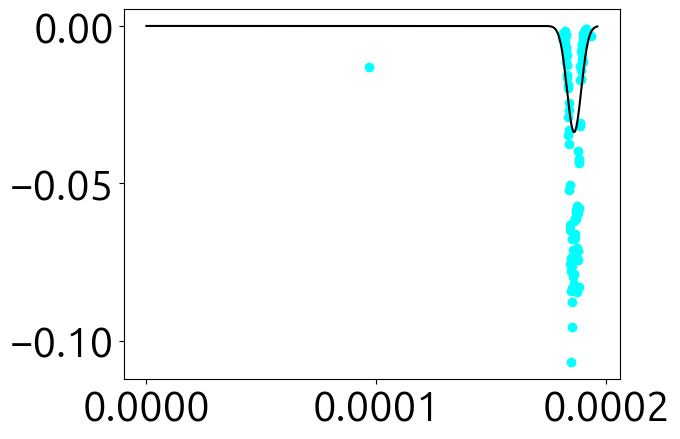

In [11]:
plt.scatter(S1Peaks[0],S1Peaks[1],color="aqua",label="EdgedTrigger")
plt.scatter(S2Peaks[0],S2Peaks[1],color="aqua",label="EdgedTrigger")
plt.plot(s1[1],gaussian1d(s1[1],*popt),color="black",label="Fit to Smoothed Event")


In [12]:
def MultiGausianFit(multival,mn=None,sg=None,maxfev=10000,SIteration=1200,vmin=-0.001,isplot=True):
    fmeans=np.array([])
    fstds=np.array([])
    counter=0
    pltlim=5
    for single in multival:
        ss=Smoothing(multival[single],SIteration)
        if((np.min(ss[0])>vmin) or (np.mean(ss[1])>=-0.5*np.min(ss[1]) and np.mean(ss[1])<=0.5*np.max(ss[1])) ) :
            continue
        if(mn==None and sg==None):    
            p0=np.min(ss[0]),np.mean(ss[1]),np.std(ss[1])
        else:
            p0=np.min(ss[0]),mn,sg
        try:
            popt, pcov = opt.curve_fit(gaussian1d,ss[1],ss[0],p0,maxfev=maxfev)
        except:
            continue
        fmeans=np.append(fmeans,popt[1])
        fstds=np.append(fstds,popt[2])
        if(isplot and pltlim>counter):
            
            plt.plot(ss[1],ss[0],label="smooted")
            plt.plot(ss[1],gaussian1d(ss[1],*popt),label="Fitted")
            plt.legend()
            plt.show()
            
            
        counter+=1
    
    return fmeans,fstds

In [13]:
#files=ListofFiles("/media/ilker/Ilker_SSD/10_07bar_6_21_23/Osiloscope/11_3k_2.3k_2k/pulse_width/")
#multivalue=getValues(files,nFiles=-1,skip=5)